In [1]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


2023-06-22 21:08:12.198545: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-22 21:08:12.402535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 21:08:13.022085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train_data = []  # List to store image-mask pairs

for directory_path in glob.glob("images_small/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img_name = os.path.basename(img_path)
        mask_path = os.path.join("mask-small/", img_name[:-4] + ".png")
        
        if os.path.exists(mask_path):  # Check if mask exists for the current image
            img = cv2.imread(img_path, 0)  # Read the image as grayscale
            img = cv2.resize(img, (256, 256))
            
            mask = cv2.imread(mask_path, 0)  # Read the mask as grayscale
            mask = cv2.resize(mask, (256, 256))
            
            train_data.append((img, mask))

# Convert list of image-mask pairs to separate arrays for machine learning processing
train_images = np.array([pair[0] for pair in train_data])
train_masks = np.array([pair[1] for pair in train_data])


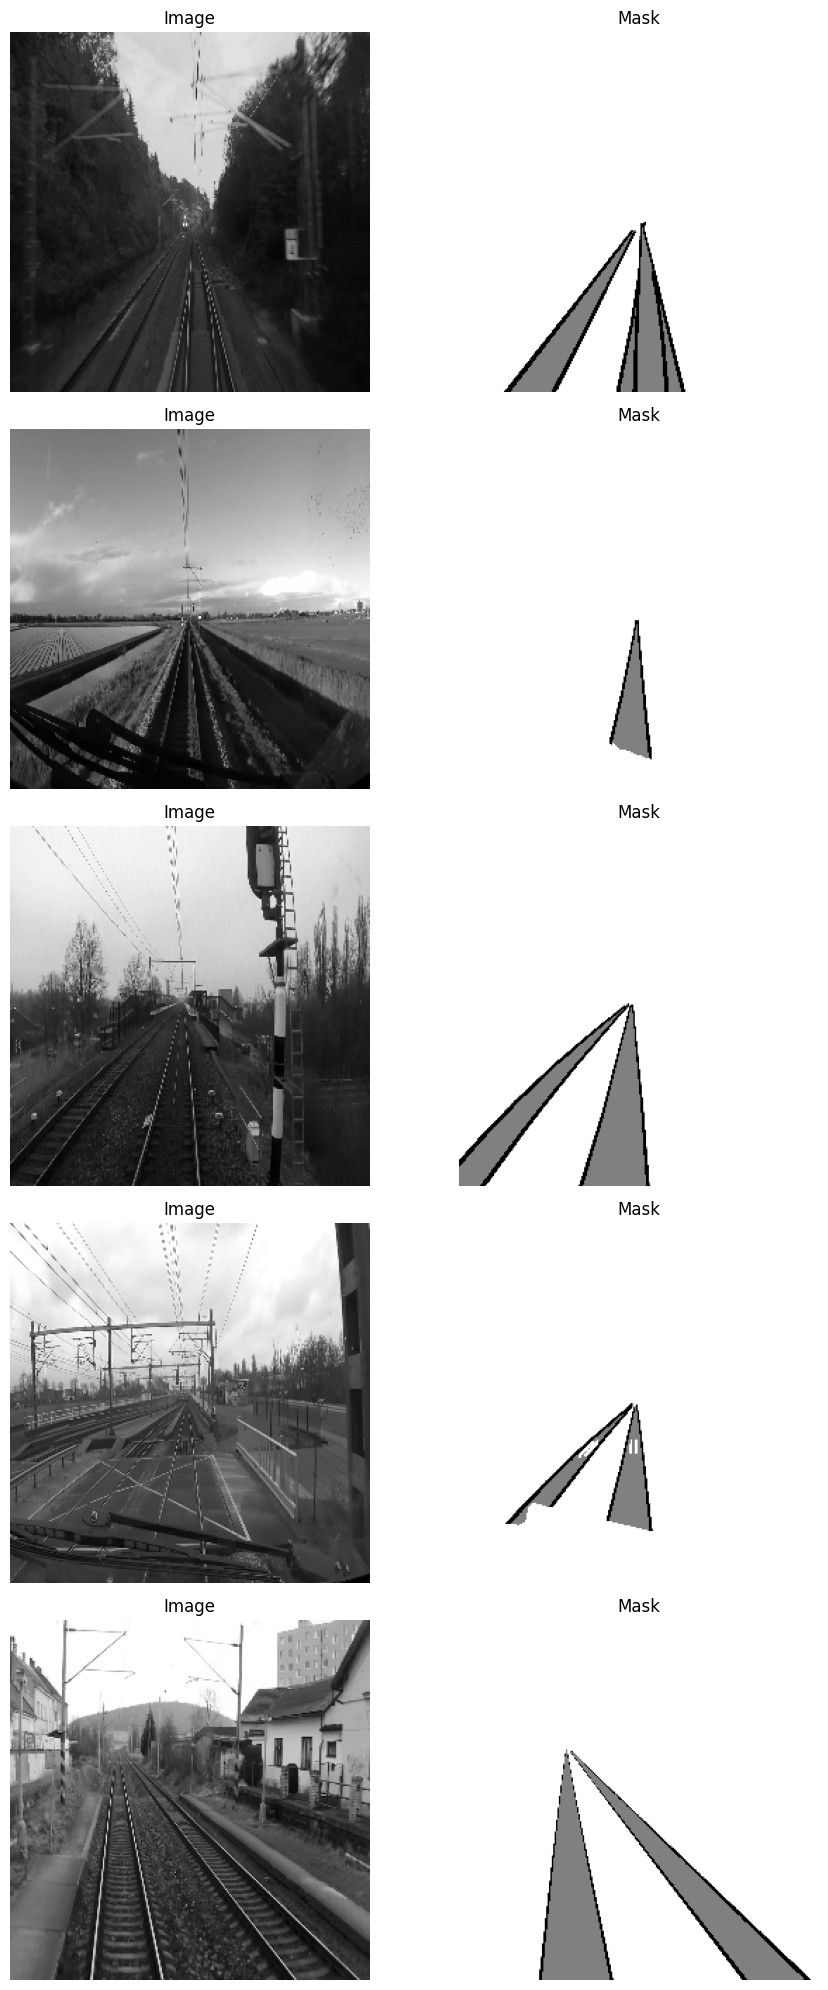

In [4]:
import matplotlib.pyplot as plt

# Plot 5 pairs of images and masks
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    # Plot image
    axes[i, 0].imshow(train_images[i], cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    
    # Plot mask
    axes[i, 1].imshow(train_masks[i], cmap='gray')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-06-22 15:01:49.246778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-22 15:01:49.246843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pratham-HP-Pavilion-Gaming-Laptop-15-dk0xxx
2023-06-22 15:01:49.246859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pratham-HP-Pavilion-Gaming-Laptop-15-dk0xxx
2023-06-22 15:01:49.247000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2023-06-22 15:01:49.247052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2023-06-22 15:01:49.247065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


[]

In [5]:
print(train_masks.shape)

(1207, 256, 256)


In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

labelencoder = LabelEncoder()

n, h, w = train_masks.shape
train_masks_encoded_original_shape = np.zeros((n, h, w), dtype=np.int32)

batch_size = 100

for i in range(0, n, batch_size):
    batch = train_masks[i:i+batch_size].reshape(-1, 1)
    batch_encoded = labelencoder.fit_transform(batch.ravel())
    train_masks_encoded_original_shape[i:i+batch_size] = batch_encoded.reshape(-1, h, w)

unique_classes = np.unique(train_masks_encoded_original_shape)
print(unique_classes)


[0 1 2]


In [7]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [8]:
unique_classes = np.unique(train_masks_input)

num_classes = len(unique_classes)
print("Number of classes:", num_classes)
print("Unique classes:", unique_classes)

Number of classes: 3
Unique classes: [0 1 2]


In [9]:
print(train_images.shape)
print(train_masks_input.shape)

(1207, 256, 256, 1)
(1207, 256, 256, 1)


In [10]:
from sklearn.model_selection import train_test_split

# Reshape train_masks_input to have the same number of samples as train_images
train_masks_input = train_masks_input[:len(train_images)]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

# Further splitting the training data for quick testing
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print('Class values in the dataset are:', np.unique(y_train))


Class values in the dataset are: [0 1 2]


In [11]:
from keras.utils import to_categorical
n_classes=3
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [12]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(train_masks_reshaped_encoded),
#                                                 train_masks_reshaped_encoded)
#print("Class weights are...:", class_weights)

In [13]:
# Define input shape and number of classes
input_shape = (256, 256, 1)
num_classes = 3
batch_size = 1

In [14]:
from simple_multi_unet_model import multi_unet_model #Uses softmax 

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

model.save('rail-u-net-model_saved-v2')  # 'model_saved' is the directory where the SavedModel will be saved
model.save('rail-u-net-model-v2.h5')
model.save('rail-u-net-model-v2.hdf5')

2023-06-22 21:09:34.956872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-22 21:09:34.956910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: user-System-Product-Name
2023-06-22 21:09:34.956916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: user-System-Product-Name
2023-06-22 21:09:34.957020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-06-22 21:09:34.957039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-06-22 21:09:34.957043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

2023-06-22 21:36:58.710610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-06-22 21:36:58.721099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023-06-22 21:36:58.731438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,64]
	 [[{{node inputs}}]]
2023-

2023-06-22 21:36:59.594883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: rail-u-net-model_saved-v2/assets


INFO:tensorflow:Assets written to: rail-u-net-model_saved-v2/assets


In [15]:
import tensorflow as tf

# Load the original saved model
saved_model_path = 'rail-u-net-model_saved-v2/'
loaded_model = tf.saved_model.load(saved_model_path)

# Convert the loaded model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Define the optimization options for post-training quantization
optimizations = [tf.lite.Optimize.DEFAULT]

# Create a converter with the optimization options
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = optimizations

# Convert the model to a quantized TensorFlow Lite model
quantized_tflite_model = converter.convert()

# Save the quantized model to a file
quantized_model_path = 'rail-u-net-model-v2.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print('Quantized model saved successfully.')


2023-06-22 21:37:01.184528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-22 21:37:01.184570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-22 21:37:01.185139: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: rail-u-net-model_saved-v2/
2023-06-22 21:37:01.188960: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-22 21:37:01.188966: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: rail-u-net-model_saved-v2/
2023-06-22 21:37:01.198824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-06-22 21:37:01.201702: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-22 21:37:01.309529: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: rail

Quantized model saved successfully.


2023-06-22 21:37:02.075464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-22 21:37:02.075486: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-22 21:37:02.075594: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: rail-u-net-model_saved-v2/
2023-06-22 21:37:02.078429: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-22 21:37:02.078439: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: rail-u-net-model_saved-v2/
2023-06-22 21:37:02.088612: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-22 21:37:02.185860: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: rail-u-net-model_saved-v2/
2023-06-22 21:37:02.209972: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Sta

In [16]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

4/4 [==============================] - 2s 369ms/step - loss: 0.1238 - accuracy: 0.9734
Accuracy is =  97.33734130859375 %


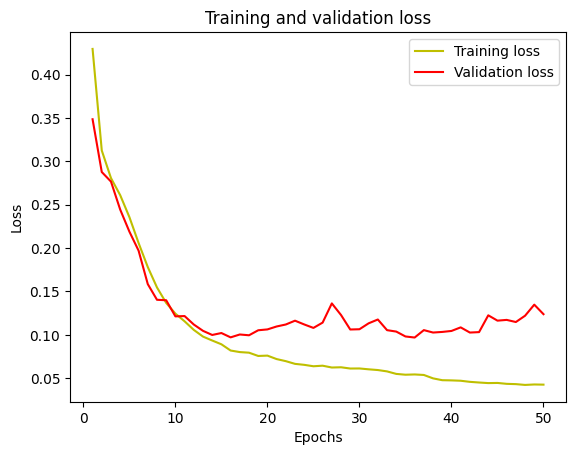

In [17]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


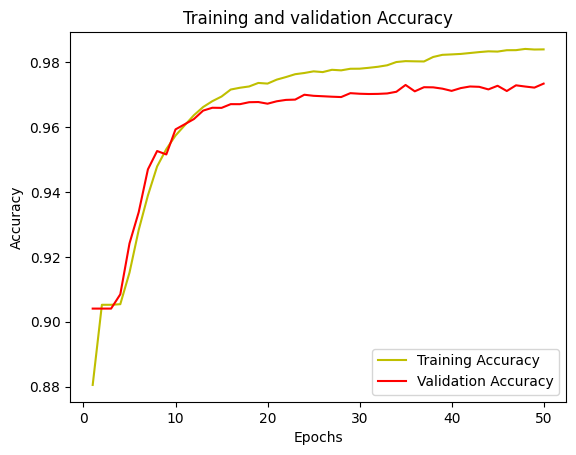

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
#model = get_model()
model.load_weights('rail-u-net-model-v2.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

4/4 [==============================] - 2s 384ms/step


In [20]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 15
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.7657183


In [21]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])

[[ 142658.   19937.   49029.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [  21298.  466935.   60947.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [  32086.   27848. 7109118.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0. 

In [22]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

IoU for class1 is:  0.53831583
IoU for class2 is:  0.78218156
IoU for class3 is:  0.97665757


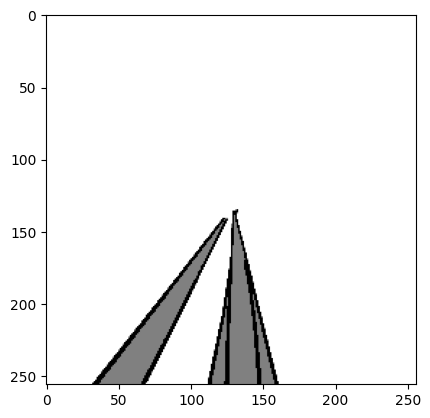

In [23]:
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 29ms/step


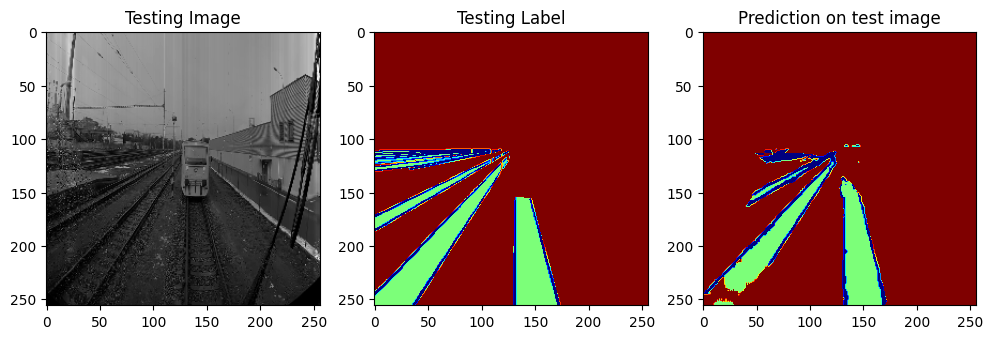

In [24]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()
